# Time Integration of Duffing Equation Using DifferentialEquation.jl

In this notebook we perform time-integration of various of (systems of) ordinary differential equations. 

Manual of [solution handling](https://docs.sciml.ai/DiffEqDocs/stable/basics/solution/#solution) in DifferentialEquations.jl.  

In [15]:
using LinearAlgebra
using DifferentialEquations
using FFTW
using Plots 

## Section 1: Single ODE Example: Linear Right-Hand Side Function 

This example was taken from https://docs.sciml.ai/DiffEqDocs/stable/tutorials/ode_example/#Example-1-:-Solving-Scalar-Equations For this example, a reference solution can be constructed using seperation of variables (or using sympy, or wolframalpha). We also plot the time-step evoution.

In this example we solve
$$
\frac{du}{dt} = f(u,p,t)
$$

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


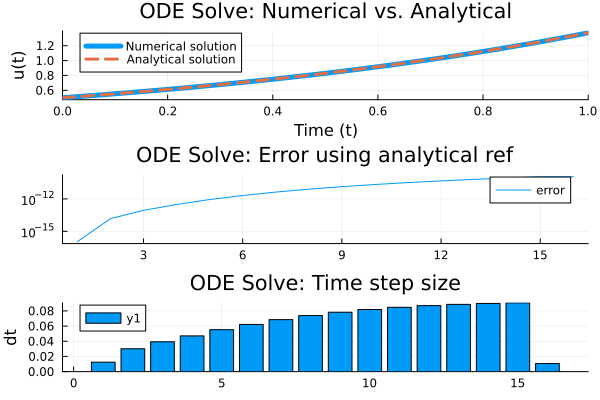

In [2]:
# problem set-up: set driving function 
f(u,p,t) = 1.01*u
# problem set-up: set initial guess 
u0=1/2
# problem set-up: set the time span 
tspan = (0.0,1.0)
# set ODE function (not strictly necessary at this stage)
ff = ODEFunction(f)
# problem set-up: define the ODE problem 
prob = ODEProblem(ff,u0,tspan)

# perform time integration 
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

#sol = solve(prob,Tsit5())

# compute the time step 
dt = collect(sol.t[i+1]-sol.t[i] for i in 1:length(sol.t)-1) # same as a list comprehension

sampled = collect(0.5*exp(1.01t) for t in sol.t) # analytical solution

merror = abs.(sol.u - sampled)

# plot numerical and analytical solution 
p1=plot(sol,linewidth=5,title="ODE Solve: Numerical vs. Analytical",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical solution") # legend=false

p1=plot!(sol.t, t->0.5*exp(1.01t),lw=3,ls=:dash,label="Analytical solution");

p2=plot(merror[2:end], yaxis=:log, label="error", title="ODE Solve: Error using analytical ref");

p3=bar(dt,yaxis="dt", title="ODE Solve: Time step size"); 

plot(p1,p2,p3,layout=(3,1))

In [3]:
display(prob);

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


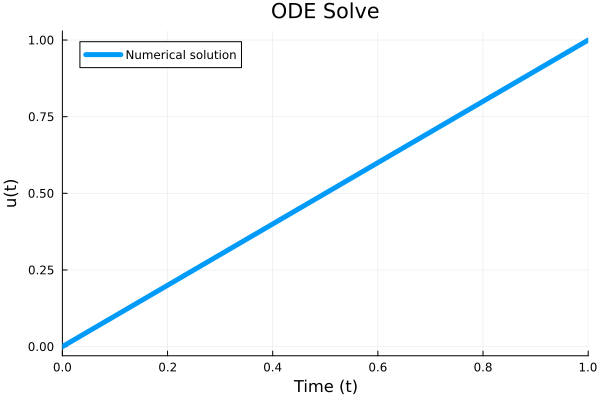

In [4]:
# problem set-up: set driving function 
f(u,p,t) = 1.
# problem set-up: set initial guess 
u0=0 
# problem set-up: set the time span 
tspan = (0.0,1.0)
# set ODE function (not strictly necessary at this stage)
ff = ODEFunction(f)
# problem set-up: define the ODE problem 
prob = ODEProblem(ff,u0,tspan)

# perform time integration 
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

# plot numerical and analytical solution 
p1=plot(sol,linewidth=5,title="ODE Solve",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical solution") 

 ## Section 2: Coupled System Example: Lorenz

This example is taken from https://docs.sciml.ai/DiffEqDocs/stable/tutorials/ode_example/#Example-2:-Solving-Systems-of-Equations.

In this example we solve:

$$
\frac{dx}{dt} = \sigma(y-x)\\
\frac{dy}{dt} = x(\rho - z)-y \\
\frac{dz}{dt} = xy-\beta z
$$

with $\beta = 8/3$, $\sigma = 10$ and $\rho = 28$

In [5]:
function lorenz!(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end

lorenz! (generic function with 1 method)

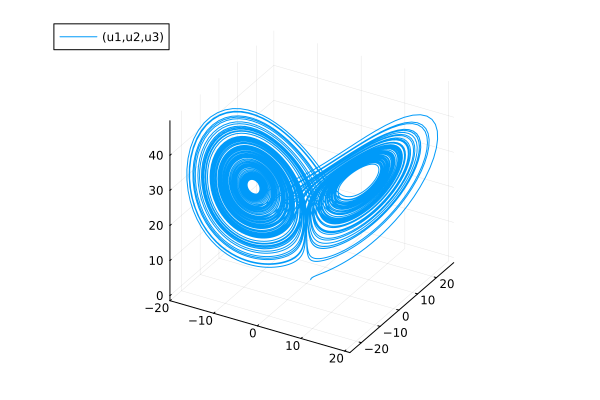

In [6]:
u0 = [1.0,0.0,0.0] # initial condition
tspan = (0.0,100.0) # time span

prob = ODEProblem(lorenz!,u0,tspan)

sol = solve(prob)

# plotly() # make the plots interactive if you want

plot(sol, idxs=(1,2,3))
# plot(sol)

##  Section 3: Oscillating Mass-Spring System as Second Order ODE 

The example that follows was taken from here [https://stackoverflow.com/questions/60180865/2nd-order-odes-in-julia-using-differentialequations]. The way in which the problem is presented, however, contains a bug. Here we use the function `SecondOrderODEProblem` explained https://diffeq.sciml.ai/stable/solvers/dynamical_solve/ (solvers page) and https://diffeq.sciml.ai/stable/types/dynamical_types/ (problems page). 

In the notation of `SecondOrderODEProblem`, the velocity is numbered first. 

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


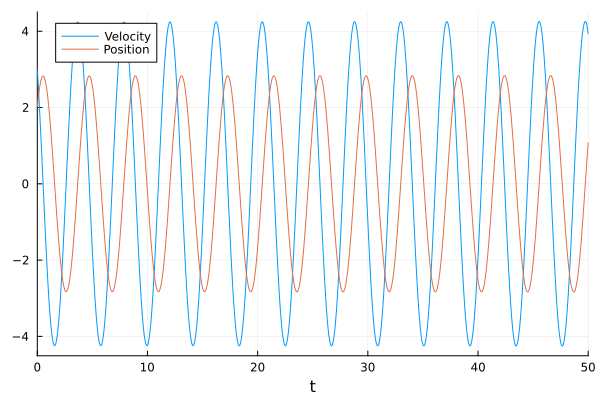

In [33]:
ω = 1.5                     

function mass_system!(ddu,u,p,t)
    # a(t) = -w^2 x 
    ddu = -(ω^2)*u 
end

v0    = 3.0                     
u0    = 2.0   
Tend  = 50
tspan = (0.0,Tend)               

prob = SecondOrderODEProblem(mass_system!,v0,u0,tspan)
sol  = solve(prob)
p1 = plot(sol)
plot(sol,idxs=1,label="Velocity")
plot!(sol,idxs=2,label="Position")

#sol(1.0)

In [34]:
# retrieve solution at time step tstep 
tstep = 11
sol(tstep)

(0.03101019319884668, -2.8294032879271542)

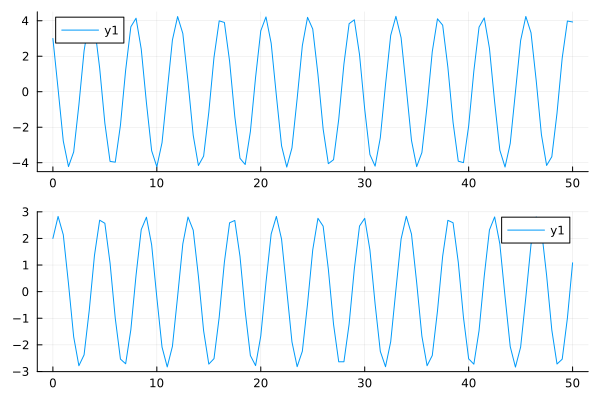

In [73]:
# retrieve velocity and position at specific sampling points 
Nsamples = 100
dt = Tend/Nsamples
tsampled = Vector(0:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]
p1 = plot(tsampled, vsampled)
p2 = plot(tsampled, usampled)
plot(p1,p2,layout = (2,1))

##  Section 4: Duffing Equation as Second Order ODE

### Section 1.4: No damping - No external forcing 

Resulting frequency of solution is eigenfrequency $\omega_0 = \sqrt{k/m}$ of the systems. This is confirmed by  FFT analysis of the solution. 

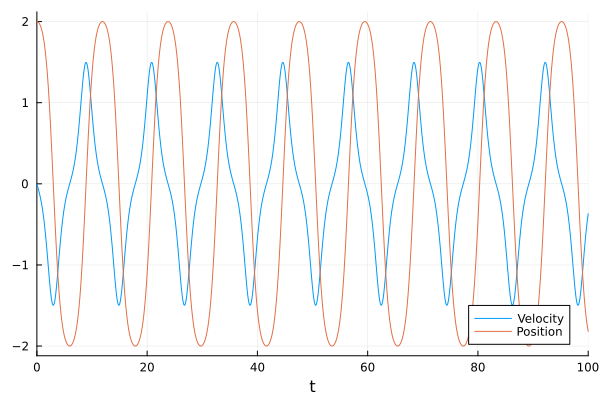

In [162]:
#..time integration.. 

#..set frequency and angular frequency of the system 
freq = .5
ω = 1; # 2 * π * freq                      

#..set initial velocity and in initial time 
v0 = 0.; # 3.0                     
u0 = 2.0    

#..set end time and time interval 
Tend = 100.0 
tspan = (0.0,Tend)               

#..set rhs function of the ODE system 
function mass_system!(ddu,u,p,t)
    ddu = -(ω^2)*u + 0.22*u^3
    # ddu = -(ω^2)*u
end

#..set problem 
prob = SecondOrderODEProblem(mass_system!,v0,u0,tspan)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

#..plot computed velocity and position 
plot(sol,idxs=1,label="Velocity")
plot!(sol,idxs=2,label="Position")

In [168]:
# retrieve velocity and position at specific sampling points 
Nsamples = 500
dt = Tend/Nsamples
tsampled = Vector(0:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

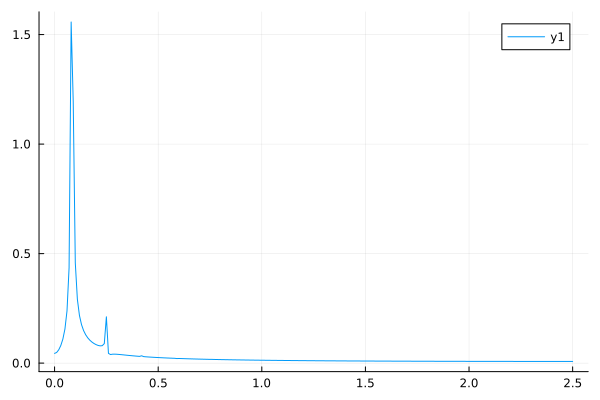

In [169]:
#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)
plot(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)])) 